In [1]:
import os
import sys
import torch

import psdr_jit as psdr
import drjit
from drjit.cuda.ad import Int as IntD, Float as FloatD, Matrix4f as Matrix4fD, Array3f as Vector3fD, Array2f as Vector2fD
from drjit.cuda import Float as FloatC, Matrix4f as Matrix4fC, Array3f as Vector3fC
from drjit.cuda import PCG32 as PCG32C, UInt64 as UInt64C

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from image_util import *

In [2]:
class MyDiffuseBSDF(psdr.BSDF):
    def __init__(self, albedo):
        psdr.BSDF.__init__(self)
        self.texture = psdr.Bitmap3fD(albedo)

    def anisotropic(self):
        return False

    def to_string(self):
        return "MyDiffuseBSDF[id=" + self.id + "]";

    def eval(self, its, wo, active):
        wo.z = drjit.mulsign(wo.z, its.wi.z);
        its.wi.z = drjit.abs(its.wi.z);
        cos_theta_i = psdr.Frame.cos_theta(its.wi)
        cos_theta_o = psdr.Frame.cos_theta(wo)
        active &= cos_theta_i > 0
        active &=  cos_theta_o > 0
        return self.texture.eval(its.uv) * psdr.InvPi * cos_theta_o & active

    def sample(self, its, sample, active):
        with drjit.suspend_grad():
            its.wi.z = drjit.abs(its.wi.z);
            cos_theta_i = psdr.Frame.cos_theta(its.wi);
            bs = psdr.BSDFSample()
            sample2 = Vector2fD(sample.x, sample.y)
            bs.wo = psdr.square_to_cosine_hemisphere(sample2);
            bs.eta = 1.0;
            bs.pdf = psdr.square_to_cosine_hemisphere_pdf(bs.wo);
            active &= cos_theta_i > 0.
            bs.is_valid = active
            return bs

    def pdf(self, its, wo, active):
        with drjit.suspend_grad():
            wo.z = drjit.mulsign(wo.z, its.wi.z);
            its.wi.z = drjit.abs(its.wi.z);
            cos_theta_i = psdr.Frame.cos_theta(its.wi);
            cos_theta_o = psdr.Frame.cos_theta(wo);
            active &= cos_theta_i > 0.
            active &= cos_theta_o > 0.
            value = psdr.InvPi * cos_theta_o;
            return value & active


In [3]:
class NerfIntegrator():
    def __init__(self, spp, width, height):
        self.width = width
        self.height = height
        self.num_pixels = self.width*self.height
        self.spp = spp
        self.sampler = psdr.Sampler()
        self.sampler.seed(drjit.arange(UInt64C, self.spp*self.num_pixels))

    def render(self, scene, sensor_id):
        result = self.render_spp(scene, sensor_id)
        return result

    def Li(self, scene, sampler, ray, active=True):
        throughput = Vector3fD(1.0)
        eta = Vector3fD(1.0)

        ray = psdr.Ray(ray.o, ray.d)
        its = scene.ray_intersectAD(ray, active)
        result = its.Le(active);
        result[drjit.isnan(result)] = 0.
        result[drjit.isinf(result)] = 0.

        return result

    def render_spp(self, scene, sensor_id):
        result = drjit.zeros(Vector3fD, self.num_pixels)
        if self.spp == 0:
            return result
        with drjit.suspend_grad():
            idx = drjit.arange(IntD, self.num_pixels)
            num_samples = self.num_pixels * self.spp
            idx = drjit.arange(IntD, num_samples)
            idx = idx // self.spp
            dx, dy = drjit.meshgrid(drjit.arange(FloatD, self.width), drjit.arange(FloatD, self.height))
            samples_base = drjit.gather(Vector2fD, Vector2fD(dx, dy), idx)
            samples = (samples_base + self.sampler.next_2d())/Vector2fD(self.width, self.height);
            ray = scene.sensor[sensor_id].sample_primary_ray(samples);
        with drjit.resume_grad():
            value = self.Li(scene, self.sampler, ray)
            drjit.scatter_reduce(drjit.ReduceOp.Add, result, value, idx)
            result /= self.spp
        return result


In [4]:
sc = psdr.Scene()
sc.opts.spp = 4
sc.opts.height = 512 
sc.opts.width = 512

integrator = NerfIntegrator(sc.opts.spp, sc.opts.height, sc.opts.width)


In [5]:
sensor = psdr.PerspectiveCamera(60, 0.000001, 10000000.)
to_world = Matrix4fD([[1.,0.,0.,0.],
                     [0.,1.,0.,0.],
                     [0.,0.,1.,-5.],
                     [0.,0.,0.,1.],])
sensor.to_world = to_world
sc.add_Sensor(sensor)


mybsdf1 = MyDiffuseBSDF([0.2, 0.9, 0.9])
sc.add_BSDF(mybsdf1, "cube")
sc.add_Mesh("./data/cube.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]), "cube", None, True)
sc.add_EnvironmentMap("data/envmap/ballroom_1k.exr", drjit.scalar.Matrix4f(np.eye(4)), 1.0)
sc.configure()


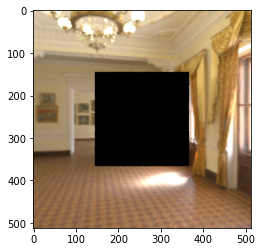

In [6]:
with drjit.suspend_grad():
    img = integrator.render(sc, 0)
    org_img = img.numpy().reshape((sc.opts.width, sc.opts.height, 3))

    org_img = to_srgb(np.asarray(org_img))
    imgplot = plt.imshow(org_img)
